# Short term flood prediction using LSTM



In [0]:
#Flood Early Warning System using IoT and Edge 
#Eric Samikwa

In [0]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import io
import keras
import requests
from matplotlib import pyplot
import matplotlib.patches as mpatches
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense     
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import metrics

plt.style.use('ggplot')


# Data pre-processing

In [0]:
# fix random seed for reproducibility
np.random.seed(10)

### Hourly rainfall data

In [0]:
#get hourly rainfall data
df_rain = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/hourly_rainfall_train.csv")

In [0]:
#display first 5
df_rain.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm)
0,2018-12-02 18:00:00,0.0,0.0
1,2018-12-02 17:00:00,0.0,0.0
2,2018-12-02 16:00:00,0.0,0.0
3,2018-12-02 15:00:00,0.0,0.0
4,2018-12-02 14:00:00,0.0,0.0


In [0]:
#dataframe shape
df_rain.shape

(78848, 3)

In [0]:
#dataset properties
df_rain.describe()  


,Current rainfall (mm),Cumulative rainfall (mm)
count,78844.000000,78847.000000
mean,0.049206,0.586580
std,0.765296,2.770216
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,110.000000,111.400000


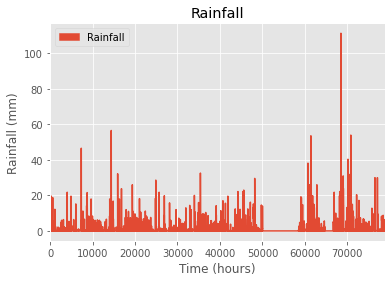

In [0]:
df_rain.plot( y='Cumulative rainfall (mm)')  

plt.title('Rainfall')  
plt.xlabel('Time (hours)')  
plt.ylabel('Rainfall (mm)')  
rainfall = mpatches.Patch(color='C0', label='Rainfall')
plt.legend(handles=[rainfall])
plt.show()  

### Hourly water level data

In [0]:
#get hourly water level data
df_water_level = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/hourly_water_level_train.csv")

In [0]:
df_water_level.head()

,Date/Time,Level (m)
0,2018-12-02 17:00:00,1.61
1,2018-12-02 16:00:00,1.61
2,2018-12-02 15:00:00,1.62
3,2018-12-02 14:00:00,1.63
4,2018-12-02 13:00:00,1.63


In [0]:
df_water_level.shape

(78822, 2)

In [0]:
#dataset properties
df_water_level.describe()

,Level (m)
count,78822.000000
mean,1.453701
std,0.113859
min,0.000000
25%,1.400000
50%,1.450000
75%,1.500000
max,3.300000


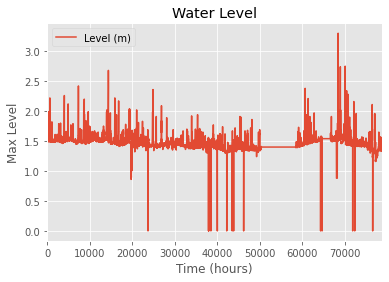

In [0]:
df_water_level.plot(y='Level (m)')  
plt.title('Water Level')  
plt.xlabel('Time (hours)')  
plt.ylabel('Max Level')  
plt.show() 

### Combining dataset

In [0]:
#dataset merged on date_time 
dataset = pandas.merge(df_rain, df_water_level, how='outer', on=['Date/Time'])
dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,NaN
1,2018-12-02 17:00:00,0.0,0.0,1.61
2,2018-12-02 16:00:00,0.0,0.0,1.61
3,2018-12-02 15:00:00,0.0,0.0,1.62
4,2018-12-02 14:00:00,0.0,0.0,1.63


### Filling missing values

In [0]:
#filling all missing values with mean of the column
dataset['Cumulative rainfall (mm)'] = dataset['Cumulative rainfall (mm)'].fillna(dataset['Cumulative rainfall (mm)'].mean())
dataset['Current rainfall (mm)'] = dataset['Current rainfall (mm)'].fillna(dataset['Current rainfall (mm)'].mean())
dataset['Level (m)'] = dataset['Level (m)'].fillna(dataset['Level (m)'].mean())

dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,1.453701
1,2018-12-02 17:00:00,0.0,0.0,1.610000
2,2018-12-02 16:00:00,0.0,0.0,1.610000
3,2018-12-02 15:00:00,0.0,0.0,1.620000
4,2018-12-02 14:00:00,0.0,0.0,1.630000


In [0]:
dataset = dataset.drop(columns=['Current rainfall (mm)', 'Date/Time'])
dataset.shape

(78850, 2)

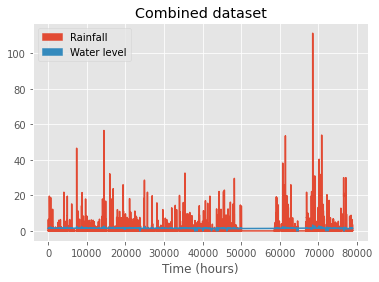

In [0]:
plt.plot(dataset)
plt.title('Combined dataset')  
plt.xlabel('Time (hours)')  
plt.ylabel('')  
rainfall = mpatches.Patch(color='C0', label='Rainfall')
level = mpatches.Patch(color='C1', label='Water level')
plt.legend(handles=[rainfall,level])
plt.show() 

### Scaling dataset 

In [0]:
# normalize the dataset (LSTMs are sensitive to the scale of the input data)
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

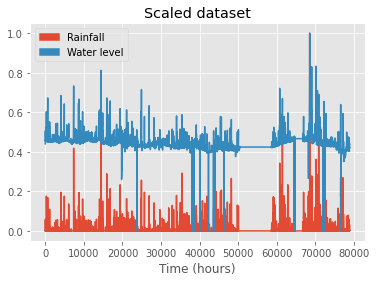

In [0]:
plt.plot(dataset)
plt.title('Scaled dataset')  
plt.xlabel('Time (hours)')  
plt.ylabel('')  
rainfall = mpatches.Patch(color='C0', label='Rainfall')
level = mpatches.Patch(color='C1', label='Water level')
plt.legend(handles=[rainfall,level])
plt.show() 

# Training 

#### Dataset sliding window (Multivariate)

In [0]:
# convert series to supervised learning
# structure data for multivariate lstm
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# specify the number of lag hours
n_hours = 10
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(dataset, n_hours, 1)
print(reframed.shape)

(78840, 22)


#### Spliting data to training and test set

In [0]:
# split into train, validation and test sets (70%, 15%, 15%)
values = reframed.values
n_train_hours = 55100 # approx 70% of the dataset
n_test_offset = 66900 # approx 15 % of the dataset 
train = values[:n_train_hours, :]
validate= values[n_train_hours:n_test_offset, :]
test = values[n_test_offset:, :]

In [0]:
#training data shape
print(train.shape)
#test data shape
print(test.shape)
#test data shape
print(validate.shape)

(55100, 22)
(11940, 22)
(11800, 22)


In [0]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
validate_X, validate_y = validate[:, :n_obs], validate[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

(55100, 20) 55100 (55100,)


#### Reshaping to LSTM input format

In [0]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
validate_X = validate_X.reshape((validate_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validate_X.shape, validate_y.shape)

(55100, 10, 2) (55100,) (11940, 10, 2) (11940,) (11800, 10, 2) (11800,)


## Model (LSTM)

In [0]:
#Setup the LSTM model (multivariate)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________


## Model Learning

### training and validation

In [0]:
#training : 50 epochs and batch size 64
history = model.fit(train_X, train_y, nb_epoch=50, batch_size=64, validation_data=(validate_X, validate_y), shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 55100 samples, validate on 11800 samples
Epoch 1/50
55100/55100 [==============================] - 9s 162us/step - loss: 0.0028 - val_loss: 2.5048e-04
Epoch 2/50
55100/55100 [==============================] - 8s 151us/step - loss: 1.7733e-04 - val_loss: 1.8791e-04
Epoch 3/50
55100/55100 [==============================] - 9s 156us/step - loss: 1.3900e-04 - val_loss: 1.4265e-04
Epoch 4/50
55100/55100 [==============================] - 8s 148us/step - loss: 1.0938e-04 - val_loss: 1.2203e-04
Epoch 5/50
55100/55100 [==============================] - 8s 154us/step - loss: 1.0227e-04 - val_loss: 1.0770e-04
Epoch 6/50
55100/55100 [==============================] - 9s 161us/step - loss: 9.5612e-05 - val_loss: 9.4586e-05
Epoch 7/50
55100/55100 [==============================] - 8s 154us/step - loss: 9.3785e-05 - val_loss: 9.3251e-05
Epoch 8/50
55100/55100 [==============================] - 9s 157us/step - loss: 9.1541e-05 - val_loss: 8.6839e-05
Epoch 9/50
55100/55100 [==================

###training performance

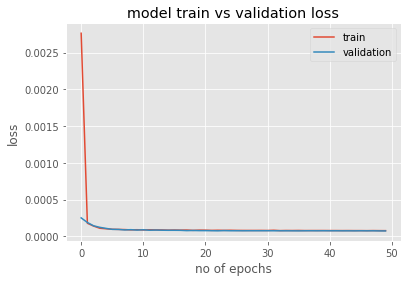

In [0]:
# plot loss during training
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title('model train vs validation loss')
plt.xlabel('no of epochs')  
plt.ylabel('loss') 
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
# model RMSE
train_score = model.evaluate(train_X, train_y, verbose=1)
train_score = math.sqrt(train_score)

validation_score = model.evaluate(validate_X, validate_y, verbose=1)
validation_score = math.sqrt(validation_score)
print('Train Score: %.2f %% RMSE' % (train_score*100))
print('Validation Score: %.2f %% RMSE' % (validation_score*100))

11800/11800 [==============================] - 1s 51us/step
Train Score: 0.85 % RMSE
Validation Score: 0.86 % RMSE


# Testing

### predictions using unseen test data 
#### 10 hours ahead of time prediction







In [0]:
# make predictions
predictions = model.predict(test_X)
unseen_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [0]:
# invert scaling for forecast
inv_predictions = concatenate((unseen_X[:,-1:],predictions), axis=1)

inv_predictions = scaler.inverse_transform(inv_predictions)

inv_predictions = inv_predictions[:,1]

In [0]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_waterlelvels = concatenate((unseen_X[:, -1:],test_y), axis=1)
inv_waterlelvels = scaler.inverse_transform(inv_waterlelvels)
inv_waterlelvels = inv_waterlelvels[:,1]

###predictions vs ground truth

----------------- Predicted ---------------


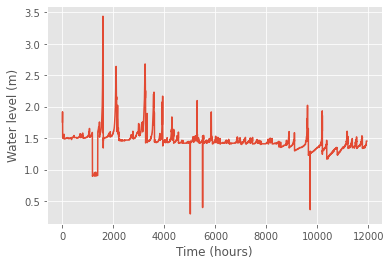

----------------- Ground Truth ---------------


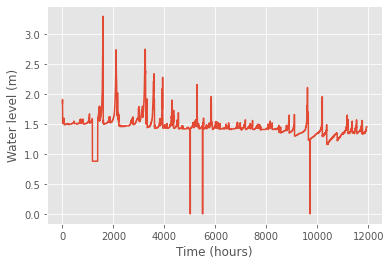

In [0]:
print('----------------- Predicted ---------------')
plt.plot(inv_predictions)
plt.xlabel('Time (hours)')  
plt.ylabel('Water level (m)') 
plt.show()
print('----------------- Ground Truth ---------------')
plt.plot(inv_waterlelvels)
plt.xlabel('Time (hours)')  
plt.ylabel('Water level (m)') 
plt.show()

#Performance Evaluation
###model performance on unseen data



In [0]:
# root mean squared error (RMSE)
rmse = sqrt(mean_squared_error(inv_waterlelvels, inv_predictions))
print('Test RMSE: %.3f %% ' % (rmse*100))

Test RMSE: 3.795 % 


In [0]:
# Mean absolute error
mae = keras.metrics.mean_absolute_error(inv_waterlelvels, inv_predictions)
print(mae)

Tensor("Mean_1:0", shape=(), dtype=float64)


#Demo

In [0]:
# this section emulates the steps for processing and predicting a flood occurency from sensor data
# realtime_data is the array containing sensor data in this case
# a flood occurancy is likely when the predicted water level exceeds 1.5 m (according to the dataset)

In [0]:
#10 hours historical data (sensor data)
 realtime_data = {'rainfall (mm)': [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0],
        'Level (m)': [0.34051556,0.44051556,0.44051556,0.42424242,0.42424242,0.42624242,0.42424242,0.42424242,0.42424242,0.42424242,0.42424242]
        }
demo_df = pandas.DataFrame(realtime_data, columns = ['rainfall (mm)', 'Level (m)'])

print (demo_df.head())

   rainfall (mm)  Level (m)
0            0.0   0.340516
1            0.0   0.440516
2            0.0   0.440516
3            0.0   0.424242
4            0.0   0.424242


In [0]:
#scaling data 
#scaler  = MinMaxScaler(feature_range=(0, 1))
#demo_dataset = scaler.fit_transform(demo_df)

In [0]:
#reframe
demo_data = demo_df.to_numpy()
#demo_data = concatenate((demo_data, demo_data,demo_data), axis=1)
print(demo_data.shape)
reframed_data = series_to_supervised(demo_data, n_hours, 1)
reframed_data = reframed_data.values
reframed_data = reframed_data[:,:20]
print(reframed_data.shape)

(11, 2)
(1, 20)


In [0]:
#reshaping
reframed_data = reframed_data.reshape((reframed_data.shape[0], n_hours, n_features))
# print(reframed_data.shape)

In [0]:
#make prediction (10 hours ahead of time)
predicted_waterlevel = model.predict(reframed_data)

print(predicted_waterlevel)

[[0.43011835]]


In [0]:
# invert scaling for forecast
inv_predicted_waterlevel = predicted_waterlevel[0][0] * inv_waterlelvels.max()
print(inv_predicted_waterlevel)

1.4193905621767042


In [0]:
#@title Flood possibility

print('Expected water level in 10 hours is %.3f m' % inv_predicted_waterlevel )

#based on the dataset it is likely to flood when predicted water level exceeds 1.5 m
if (inv_predicted_waterlevel > 1.5):
  print("FLOOD")
else:
  print("No FLOOD")

Expected water level in 10 hours is 1.419 m
No FLOOD
